* 회귀의 경우 대부분 실제값과 예측값의 오차 평균값에 기반
* 분류의 경우
    * 이진 분류 / 멀티 분류
    * 단순한 정확도만 가지고 판단하면 잘못된 평가 결과에 빠질 수 있다.

## 01. 정확도 (Accuracy)
실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표
정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수

In [1]:
## 정확도의 잘못된 평가 결과 예시

# 앞의 타이타닉 예제에서 정확도의 결과가 80%대였지만, 여자인 경우 생존 확률이 높았기 때문에,
# 무조건 성별이 여자면 생존, 남자연 사망으로 예측해도 비슷한 수치가 나올 수 있다.

from sklearn.base import BaseEstimator  # 사이킷런은 BaseEstimator를 상속받으면 Customized 형태의 Estimator 생성 가능

class MyDummyClassifier(BaseEstimator):
    # fit() 매서드는 아무것도 학습하지 않음
    def fit(self,X,y=None):
        pass
    # predict() 매서드는 단순이 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
    def predict(self,X):
        pred = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i]==1:
                pred[i] =0
            else:
                pred[i] = 1
                
        return pred

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing


# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# Dummy Classifier를 이용해 학습, 예측, 평가
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도: {0:4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도: 0.787709


In [4]:
## 정확도의 잘못된 평가 결과 예시

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)
    
# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data,y,random_state=11)

In [5]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)

print('모든 예측을 0으로 하여도 정확도는 {:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는 0.900


이처럼 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용되어서는 안된다.

이러한 한계점을 극복하기 위해 여러 가지 분류 지표와 함께 적용해야 한다.

## 02. 오차행렬 (Confusion matrix)
* 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지도 함께 보여주는 지표
* 이직 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표

    TN    FP

    FN    TP
    

In [6]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

정확도 = 예측 결과와 실제 값이 동일한 건수 / 전체 데이터 수 = (TN + TP) / (TN + FP + FN + TP)

## 03. 정밀도(Precision)와 재현율(Recall)
* 정밀도 = 예측과 실제 값이 Positive / 예측을 Positive로 한 대상 = TP / (FP + TP)
* 재현율 = 예측과 실제 값이 Positive / 실제 값이 Positive인 대상 = TP / (FN + TP) = 민감도(Sensitivity) = TPR(True Positive Rate)

**정밀도와 재현율 지표 중에 이진 분류 모델의 업무 특성에 따라서 특정 평가 지표가 더 중요한 지표로 간주됨**
* 재현율이 중요 지표인 경우 : 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
    * 암 판단 모델
* 정밀도가 중요 지표인 경우 : 실제 Negative 양성 데이터를 Positive로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
    * 스팸 메일 분류 모델
    
 *매우 적은 수의 결괏값에 Positive로 설정하는 경우가 많음 (암 양성, 사기 거래...)*

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [8]:
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[94 16]
 [19 50]]
정확도: 0.8045, 정밀도: 0.7576, 재현율: 0.7246


C:\Users\A\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**정밀도/재현율 트레이트오프(Trade-off)**

분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다.

하지만 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한쪽을 강제로 높이면 다른 하나의 수치가 떨어지기 쉽다.

In [9]:
# predict_proba() : 개별 데이터별로 예측 확률을 반환하는 메서드, ndarray m*n 형태로 반환
# predict()는 predict_proba()기반

pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])

pred_proba() 결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.81914032 0.18085968]
 [0.87986229 0.12013771]
 [0.96322689 0.03677311]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.81914032 0.18085968 0.        ]
 [0.87986229 0.12013771 0.        ]
 [0.96322689 0.03677311 0.        ]]


In [10]:
# Binarizer 사용법

from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [15]:
from sklearn.preprocessing import Binarizer

# Binarizer의threshold 설정값 (분류 결정 임곗값)
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[94 16]
 [19 50]]
정확도: 0.8045, 정밀도: 0.7576, 재현율: 0.7246


In [16]:
# Binarizer의threshold 설정값을 0.4로 설정
custom_threshold = 0.4

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[91 19]
 [14 55]]
정확도: 0.8156, 정밀도: 0.7432, 재현율: 0.7971


In [19]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내에서 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        print()
        
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[91 19]
 [14 55]]
정확도: 0.8156, 정밀도: 0.7432, 재현율: 0.7971

임곗값: 0.45
오차 행렬
[[92 18]
 [18 51]]
정확도: 0.7989, 정밀도: 0.7391, 재현율: 0.7391

임곗값: 0.5
오차 행렬
[[94 16]
 [19 50]]
정확도: 0.8045, 정밀도: 0.7576, 재현율: 0.7246

임곗값: 0.55
오차 행렬
[[95 15]
 [23 46]]
정확도: 0.7877, 정밀도: 0.7541, 재현율: 0.6667

임곗값: 0.6
오차 행렬
[[97 13]
 [25 44]]
정확도: 0.7877, 정밀도: 0.7719, 재현율: 0.6377



In [23]:
# precision_recall_curve() : 일반적으로 0.11 ~ 0.95 정도의 임곗값을 담은 넘파이 ndarray와 이 임곗값에 해당하는 정밀도 및 재현율 값을 담은 넘파이 array 반환

from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임계값 배열 중 샘플로 10건만 추출하되, 임곗값을 15 step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (168,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150 165]
샘플용 10개의 임계값:  [0.05 0.09 0.12 0.15 0.18 0.23 0.36 0.54 0.71 0.8  0.89 0.96]
샘플 임계값별 정밀도: [0.394 0.412 0.468 0.512 0.574 0.656 0.731 0.746 0.833 0.939 1.    1.   ]
샘플 임계값별 재현율: [1.    0.957 0.957 0.928 0.899 0.884 0.826 0.681 0.58  0.449 0.261 0.043]


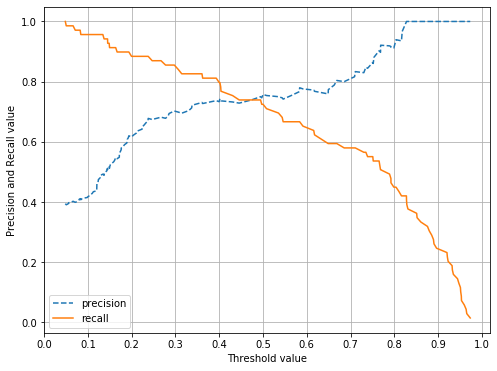

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

정밀도 또는 재현율 중 하나에 상대적인 중요도를 부여해 각 예측 상황에 맞는 분류 알고리즘을 튜닝할 수 있지만, 그렇다고 **정밀도/재현율 중 하나만 강조하는 상황이 돼서는 안된다.**